<a href="https://colab.research.google.com/github/eecheonwu/ammi_ml-proj/blob/main/AMMI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMMI project: "Geo Object Detection"

Supervisor: Dr. Y. Y. ZIGGAH
PhD, MEng (Geodesy and Survey Engineering)
BSc (Geomatic Engineering)
University of Mines and Technology
Department of Geomatic Engineering
P.O. Box 237,
Tarkwa-Western Region
Ghana
West Africa 

# Create and Annotate Datasets

In [ ]:
import os, gdal

In [ ]:
in_path = '/home/emmanuel/AMMI_Project/'
input_filename = 'Orthophoto.tif'

In [ ]:
out_path = '/home/emmanuel/AMMI_Project/Datasets/'
output_filename = 'tile_'

In [ ]:
tile_size_x = 2000
tile_size_y = 2000

In [ ]:
ds = gdal.Open(in_path + input_filename)
band = ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

In [ ]:
for i in range(0, xsize, tile_size_x):
    for j in range(0, ysize, tile_size_y):
        com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + str(in_path) + str(input_filename) + " " + str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".tif"
        os.system(com_string)


In [ ]:
! labelImg

Image:/home/emmanuel/ml-data/test/IMG_160729_071425_0013_RGB.JPG -> Annotation:/home/emmanuel/ml-data/test/IMG_160729_071425_0013_RGB.xml
Image:/home/emmanuel/ml-data/test/IMG_160729_071526_0036_RGB.JPG -> Annotation:/home/emmanuel/ml-data/test/IMG_160729_071526_0036_RGB.xml
Image:/home/emmanuel/ml-data/test/IMG_160729_071528_0037_RGB.JPG -> Annotation:/home/emmanuel/ml-data/test/IMG_160729_071528_0037_RGB.xml
Image:/home/emmanuel/ml-data/test/IMG_160729_071536_0038_RGB.JPG -> Annotation:/home/emmanuel/ml-data/test/IMG_160729_071536_0038_RGB.xml
Image:/home/emmanuel/ml-data/test/IMG_160729_071629_0058_RGB.JPG -> Annotation:/home/emmanuel/ml-data/test/IMG_160729_071629_0058_RGB.xml
TIFFReadDirectory: Warning, Unknown field with tag 33550 (0x830e) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 33922 (0x8482) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34735 (0x87af) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 34736 (0x87b0) encount

# Download Dataset

In [2]:
! git clone https://github.com/eecheonwu/ammi_ml-proj.git

Cloning into 'ammi_ml-proj'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 711 (delta 26), reused 0 (delta 0), pack-reused 663
Receiving objects: 100% (711/711), 1.15 GiB | 29.29 MiB/s, done.
Resolving deltas: 100% (398/398), done.
Checking out files: 100% (473/473), done.


# Install Utility software

In [3]:
!pip install git+https://github.com/microsoft/ComputerVision.git@master#egg=utils_cv

  Cloning https://github.com/microsoft/ComputerVision.git (to revision master) to /tmp/pip-install-zc7nm91w/utils-cv
  Running command git clone -q https://github.com/microsoft/ComputerVision.git /tmp/pip-install-zc7nm91w/utils-cv
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 215kB 10.8MB/s 
     |████████████████████████████████| 983kB 34.1MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 112kB 51.9MB/s 
     |████████████████████████████████| 2.1MB 49.6MB/s 
     |████████████████████████████████| 14.1MB 254kB/s 
     |████████████████████████████████| 194kB 48.9MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 307kB 54.4MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████

In [4]:
!pip install trains

     |████████████████████████████████| 808kB 13.3MB/s 
     |████████████████████████████████| 92kB 11.3MB/s 


# Import libraries

In [2]:
import os
import torch
import torchvision
from utils_cv.detection.dataset import DetectionDataset, get_transform
from utils_cv.detection.plot import (
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_counts_curves,
    plot_detections
)
from utils_cv.detection.model import (
    DetectionLearner,
    get_pretrained_fasterrcnn,
)

from trains import Task

In [3]:
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.8.1+cu101
Torch is using GPU: Tesla T4


In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


In [5]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
path = "/content/ammi_ml-proj"

In [7]:
os.listdir(path)

['train',
 'test_anno',
 'validation',
 'val_anno',
 '.git',
 'images',
 'train_anno',
 'README.md',
 'test',
 'annotations']

In [8]:
task = Task.init(project_name='AMMI Project', task_name='Geo Object Detection')
configuration_dict = {'n_epochs': 4, 'n_momentum': 0.5, 'n_weight_decay': 0.003, 'n_lr': 0.006, 'n_step_size': 2, 'n_gamma': 0.2}
configuration_dict = task.connect(configuration_dict)  # enabling configuration override by trains
print(configuration_dict)  # printing actual configuration (after override in remote mode)

TRAINS Task: overwriting (reusing) task id=6b47377825f246a2aa30d50126a8fe54
2020-11-20 10:11:57,341 - trains.Task - INFO - No repository found, storing script code instead
TRAINS results page: https://demoapp.trains.allegro.ai/projects/a4b8168194a1413d8dfe2719179c8541/experiments/6b47377825f246a2aa30d50126a8fe54/output/log
{'n_epochs': 4, 'n_momentum': 0.5, 'n_weight_decay': 0.003, 'n_lr': 0.006, 'n_step_size': 2, 'n_gamma': 0.2}


# Dataset Preparation

In [9]:
data = DetectionDataset(root= "/content/ammi_ml-proj", anno_dir="annotations", im_dir= "images", train_pct= 0.81 )

In [10]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 96 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f7e2f400dd8>     
Testing dataset: 22 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f7e2f1e6080>


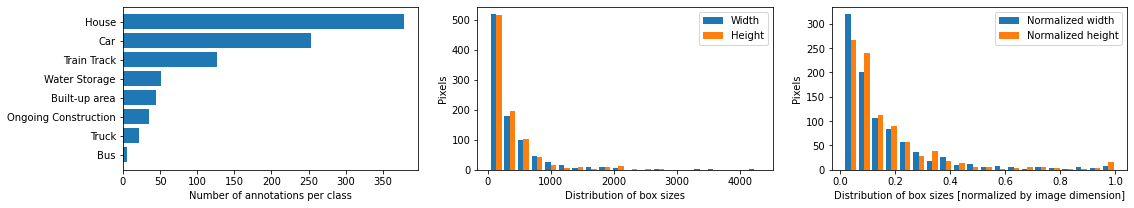

In [11]:
data.plot_boxes_stats()

Transformations applied on /content/ammi_ml-proj/images/tile_24000_12000.tif:


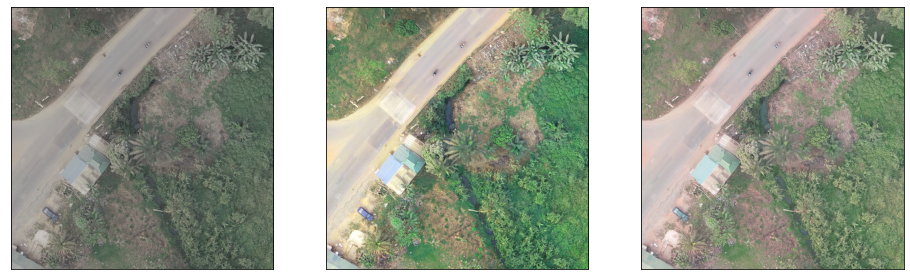

In [12]:
data.train_ds.dataset.show_im_transformations()

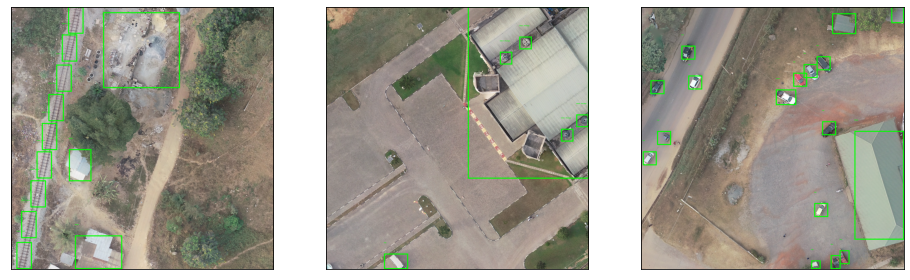

In [13]:
data.show_ims(rows=1)

# Define Model

In [14]:
detector = DetectionLearner(data, im_size=2000, labels=["House", "Car", "Ongoing Construction", "Built-up area", "Water Storage", "Bus", "Truck", "Train Track"])
print(f"Model: {type(detector.model)}")

2020-11-20 10:12:25,555 - trains.model - INFO - Selected model id: 97b12d91d2324ad2971f2632a27321fd
Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


# Train Model

In [15]:
skip_evaluation = device.type == 'cpu'

In [ ]:
detector.fit(epochs=10, lr=0.01, momentum=0.4, weight_decay=0.02, print_freq=10, step_size=2, gamma=0.2, skip_evaluation=skip_evaluation)

Epoch: [0]  [ 0/48]  eta: 0:19:19  lr: 0.000223  loss: 0.5438 (0.5438)  loss_classifier: 0.2018 (0.2018)  loss_box_reg: 0.2291 (0.2291)  loss_objectness: 0.0162 (0.0162)  loss_rpn_box_reg: 0.0967 (0.0967)  time: 24.1553  data: 21.1535  max mem: 9487
Epoch: [0]  [10/48]  eta: 0:04:29  lr: 0.002348  loss: 0.9000 (1.1269)  loss_classifier: 0.2422 (0.3470)  loss_box_reg: 0.3233 (0.4465)  loss_objectness: 0.0243 (0.0283)  loss_rpn_box_reg: 0.3163 (0.3052)  time: 7.0837  data: 4.6681  max mem: 9487
Epoch: [0]  [20/48]  eta: 0:02:14  lr: 0.004474  loss: 1.2359 (1.1982)  loss_classifier: 0.4110 (0.3915)  loss_box_reg: 0.5258 (0.5038)  loss_objectness: 0.0270 (0.0330)  loss_rpn_box_reg: 0.2763 (0.2699)  time: 3.8201  data: 1.5236  max mem: 9487
Epoch: [0]  [30/48]  eta: 0:01:11  lr: 0.006599  loss: 1.2359 (1.1131)  loss_classifier: 0.3998 (0.3745)  loss_box_reg: 0.5010 (0.4787)  loss_objectness: 0.0211 (0.0266)  loss_rpn_box_reg: 0.0563 (0.2334)  time: 2.2279  data: 0.0207  max mem: 9487


In [17]:
print('Task ID number is: {}'.format(task.id))

Task ID number is: 6b47377825f246a2aa30d50126a8fe54


# Model Evaluation

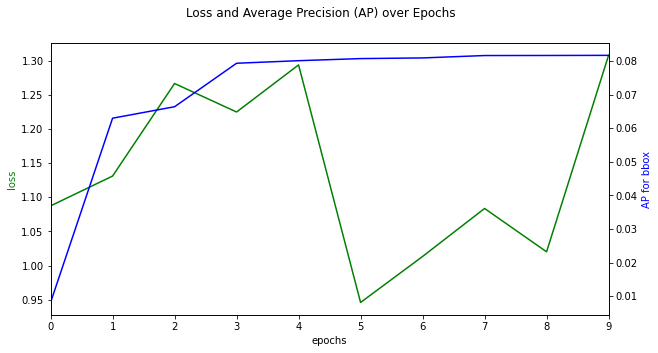

In [18]:
if not skip_evaluation:
    detector.plot_precision_loss_curves()

In [ ]:
if not skip_evaluation:
    e = detector.evaluate()

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:42  model_time: 0.9700 (0.9700)  evaluator_time: 0.0083 (0.0083)  time: 4.2098  data: 3.0587  max mem: 9599
Test:  [ 9/10]  eta: 0:00:01  model_time: 0.9215 (0.9270)  evaluator_time: 0.0083 (0.0107)  time: 1.2984  data: 0.3200  max mem: 9599
Test: Total time: 0:00:13 (1.3410 s / it)
Averaged stats: model_time: 0.9215 (0.9270)  evaluator_time: 0.0083 (0.0107)
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.135
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.048
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.186
 Average Recall     (AR) @[ IoU

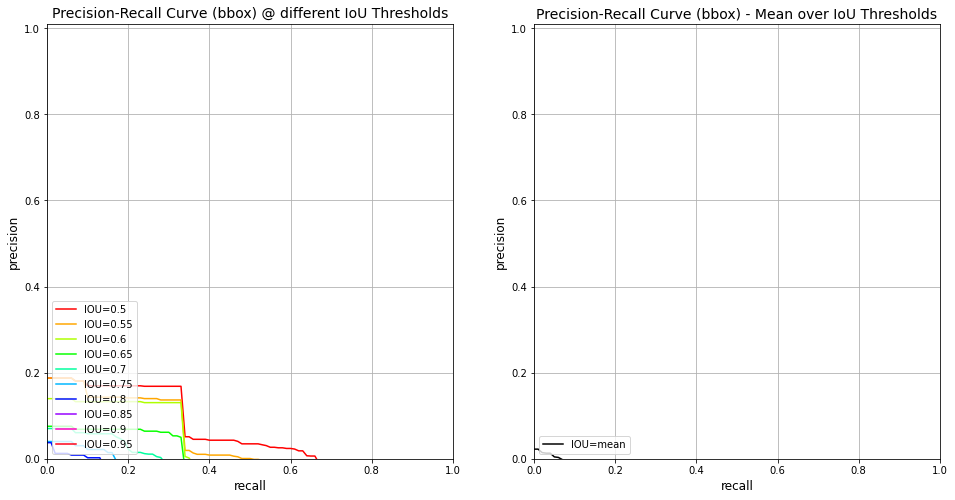

In [ ]:
if not skip_evaluation:
    plot_pr_curves(e)

# Model Prediction Test

In [ ]:
detections = detector.predict_dl(data.test_dl, threshold=0.5)

In [ ]:
detections[:5]

[{'det_bboxes': [{Bbox object: [left=162, top=1748, right=670, bottom=2000] | <House> | label:1 | path:/content/ml-data/images/tile_14000_4000.tif} | score: 0.7510794401168823,
   {Bbox object: [left=1216, top=1303, right=1366, bottom=1464] | <House> | label:1 | path:/content/ml-data/images/tile_14000_4000.tif} | score: 0.5164225697517395],
  'idx': 20,
  'im_path': '/content/ml-data/images/tile_14000_4000.tif'},
 {'det_bboxes': [{Bbox object: [left=979, top=54, right=1135, bottom=174] | <Car> | label:3 | path:/content/ml-data/images/tile_14000_14000.tif} | score: 0.9612022638320923,
   {Bbox object: [left=1171, top=243, right=1321, bottom=378] | <Car> | label:3 | path:/content/ml-data/images/tile_14000_14000.tif} | score: 0.9473283886909485,
   {Bbox object: [left=1445, top=135, right=1590, bottom=298] | <Car> | label:3 | path:/content/ml-data/images/tile_14000_14000.tif} | score: 0.9409239292144775,
   {Bbox object: [left=1575, top=243, right=1694, bottom=395] | <Car> | label:3 | pat

In [ ]:
print(
    f"Number of detections: {len(detections)}\nNumber of test images: {len(data.test_ds)}"
)

Number of detections: 20
Number of test images: 20


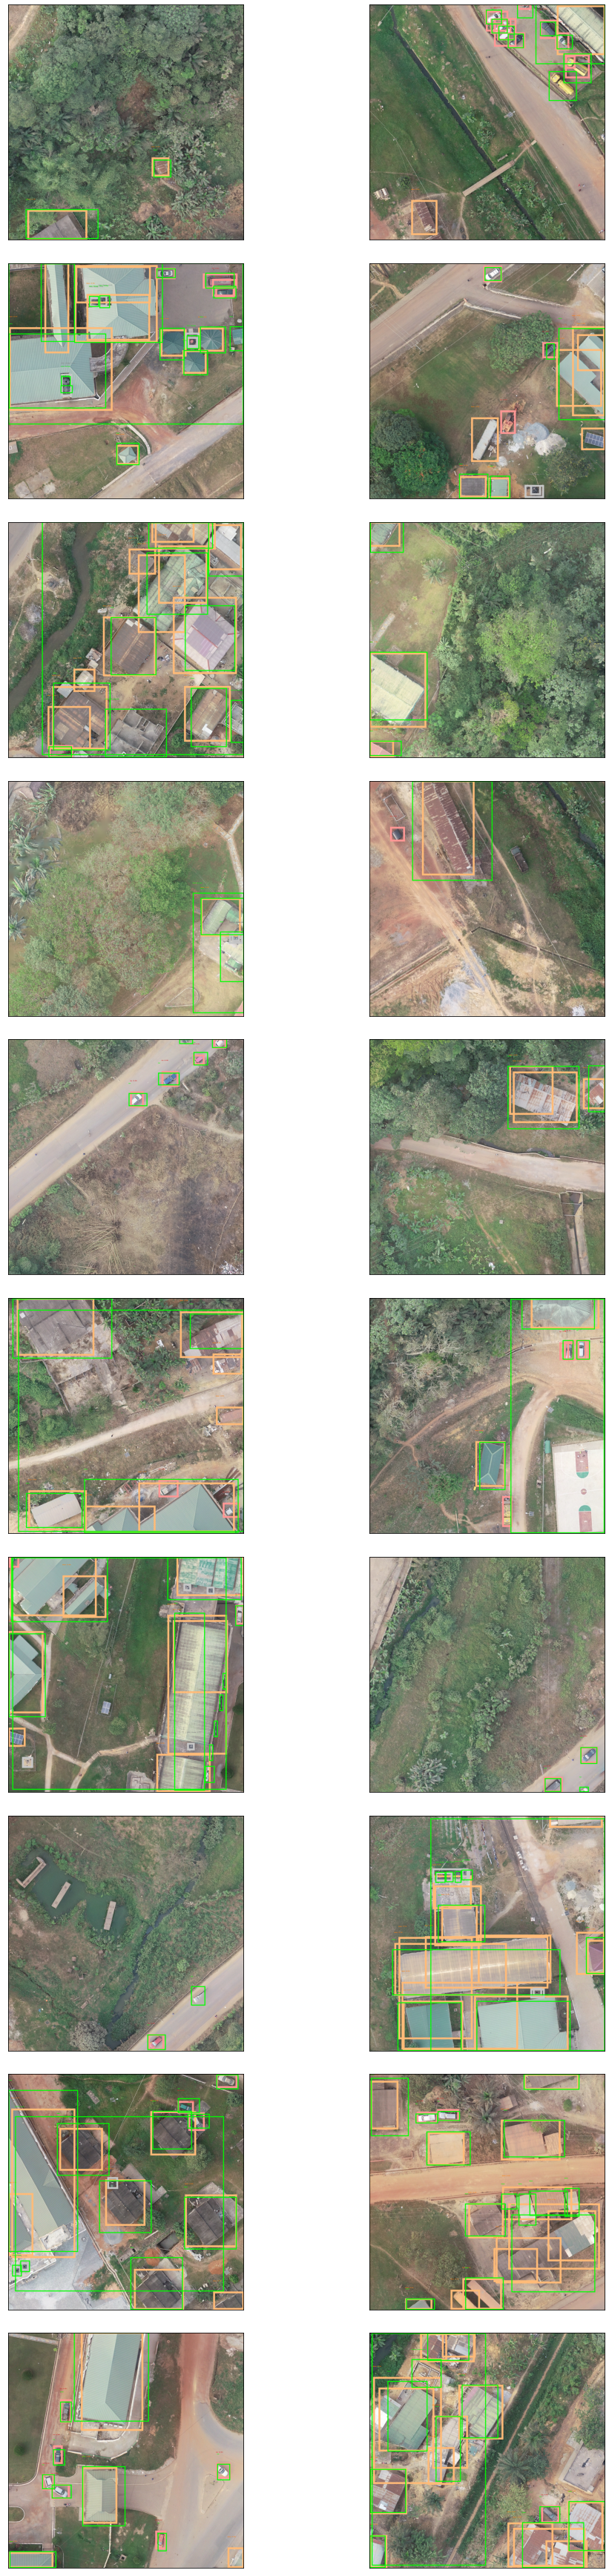

In [ ]:
def _grid_helper():
    for detection in detections:
        yield detection, data, None, None 
plot_grid(plot_detections, _grid_helper(), rows=10, cols=2)

# Method 2

In [ ]:
! git clone https://github.com/eecheonwu/ammi_ml-proj.git

Cloning into 'ml-data'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 661 (delta 1), reused 0 (delta 0), pack-reused 655
Receiving objects: 100% (661/661), 1.13 GiB | 30.21 MiB/s, done.
Resolving deltas: 100% (367/367), done.
Checking out files: 100% (430/430), done.


In [ ]:
! pip install detecto

In [ ]:
import matplotlib.pyplot as plt
from detecto import utils, visualize
from detecto.utils import read_image
from detecto.utils import xml_to_csv
from detecto.visualize import show_labeled_image
from torchvision import transforms
from detecto.utils import normalize_transform
from detecto.core import DataLoader,Dataset, Model
from detecto.visualize import plot_prediction_grid, detect_video, detect_live

In [ ]:
custom_transforms = transforms.Compose([
    transforms.ToPILImage(),
    # Note: all images with a size smaller than 800 will be scaled up in size
    transforms.Resize(2000),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(saturation=0.2),
    transforms.ToTensor(),  # required
    normalize_transform(),  # required
])

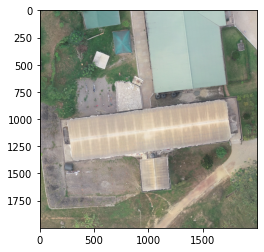

In [ ]:
image = read_image('/content/ammi_ml-proj/images/tile_10000_10000.tif')
plt.imshow(image)
plt.show()

In [ ]:
xml_to_csv('/content/ammi_ml-proj/annotations/', 'train_labels.csv')
xml_to_csv('/content/ammi_ml-proj/val_anno/', 'val_labels.csv')
xml_to_csv('/content/ammi_ml-proj/test_anno/', 'test_labels.csv')


train_dataset = Dataset('train_labels.csv', '/content/ammi_ml-proj/images/', transform=custom_transforms)
val_dataset = Dataset('val_labels.csv', '/content/ammi_ml-proj/validation/')
test_dataset = Dataset('test_labels.csv', '/content/ammi_ml-proj/test/')

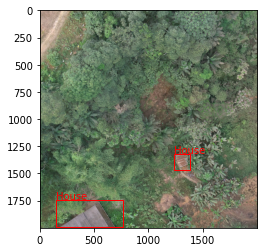

In [ ]:
image, targets = train_dataset[1]
show_labeled_image(image, targets['boxes'], targets['labels'])

In [ ]:
object_labels = ['House', 'Car', 'Ongoing Construction', 'Built-up area', 'Water Storage', 'Bus', 'Truck', 'Train Track']
model = Model(object_labels)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 1.1287355497479439
Epoch 2 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.9767137964566549
Epoch 3 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.9243829995393753
Epoch 4 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8705961629748344
Epoch 5 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.881331724425157
Epoch 6 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.9197570358713468
Epoch 7 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.9147118280331293
Epoch 8 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8560313557585081
Epoch 9 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8727807303269705
Epoch 10 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8740886424978574
Epoch 11 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.9125433440009753
Epoch 12 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8987007290124893
Epoch 13 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.886705182492733
Epoch 14 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8761705706516901
Epoch 15 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8868872871001562
Epoch 16 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8938984299699465
Epoch 17 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8713585088650385
Epoch 18 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8929190933704376
Epoch 19 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


  0%|          | 0/55 [00:00<?, ?it/s]

Loss: 0.8513330072164536
Epoch 20 of 20
Begin iterating over training dataset


  0%|          | 0/12 [00:00<?, ?it/s]

Begin iterating over validation dataset


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]

Loss: 0.904473640024662


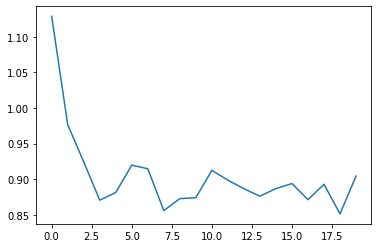

In [ ]:
# Alternatively, provide your own DataLoader to the fit method
loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
losses = model.fit(loader, val_dataset, epochs=20, learning_rate=0.001,gamma=0.2, lr_step_size=2, verbose=True)
plt.plot(losses)
plt.show()

In [ ]:
images = []
for i in range(16):
    image, _ = test_dataset[i]
    images.append(image)

top_predictions = model.predict_top(images)

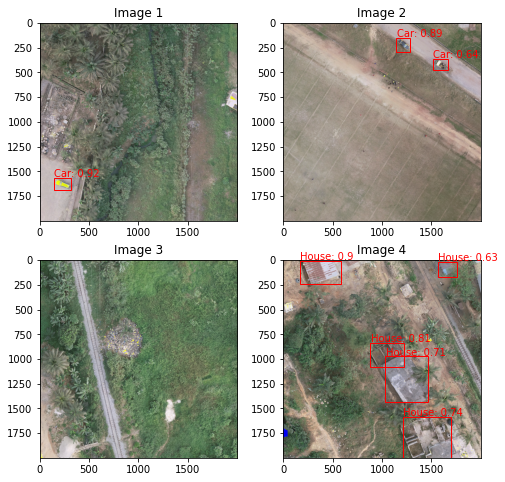

In [ ]:
plot_prediction_grid(model, images, dim=(4, 4), figsize=(12, 12))

In [ ]:
torch_model = model.get_internal_model()
print(type(torch_model))

<class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>
